### Datasets
    - gdsc --> gg
    - ctrp --> cc
### Models
    - lgb
    - nn0
    - nn1

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from load_modules import *
%matplotlib inline
fpath = Path(os.getcwd())
print('Current path:', fpath)

outpath = fpath/'summit_fits'
os.makedirs(outpath, exist_ok=True)

Current path: /vol/ml/apartin/projects/dr-learning-curves/nbs


## Path to data

In [3]:
method = 'ls_hpo'
# method = 'ps_hpo'

In [4]:
fname = 'all_scores.csv'
# dpath = Path('../lc.out')
# dpath = Path('../lc.summit.run', method)
dpath = Path('../lc.summit.run')

# dirs = sorted(dpath.glob('*'))
dirs = glob(str(dpath/'*'))
print(dirs)

['../lc.summit.run/ls_hpo_low', '../lc.summit.run/ls_hpo_high', '../lc.summit.run/lc.gdsc.nn_reg0.ls_hpo', '../lc.summit.run/lc.gdsc.nn_reg1.ls_hpo', '../lc.summit.run/ps_hpo', '../lc.summit.run/agg_scores_hpc.ipynb']


In [5]:
src = 'GDSC'
nn0_path = Path(dpath, f'lc.gdsc.nn_reg0.{method}', fname)
nn1_path = Path(dpath, f'lc.gdsc.nn_reg1.{method}', fname)
lgb_path = Path('../lc.out/lc.gdsc.lgb', fname)

# src = 'CTRP'
# nn0_path = dpath/'../lc.summit.run/lc.ctrp.nn_reg0.ps_hpo'/fname
# nn1_path = dpath/'../lc.summit.run/lc.ctrp.nn_reg1.ps_hpo'/fname
# lgb_path = dpath/'../lc.out/lc.ctrp.lgb'/fname

## Load data

In [6]:
nn0 = load_data(nn0_path, tr_set='te');
nn1 = load_data(nn1_path, tr_set='te');
lgb = load_data(lgb_path, tr_set='te');

## Raw plots

In [27]:
# Global plotting params
# -------------------------------
# met = 'mean_absolute_error'
met = 'median_absolute_error'
t_set = 'te'
xtick_scale = 'log2'
ytick_scale = 'log2'
# xtick_scale = 'linear'
# ytick_scale = 'linear'
kwargs = {'metric_name': met, 'tr_set': t_set, 'xtick_scale': xtick_scale, 'ytick_scale': ytick_scale, 'plot_median': True}

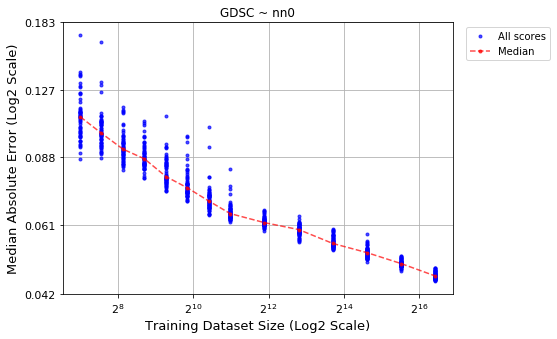

In [28]:
# Plot
# -------------------------------
kwargs.update({'title': f'{src} ~ nn0'})
ax = lc_plots.plot_lc_single_metric(nn0, **kwargs);

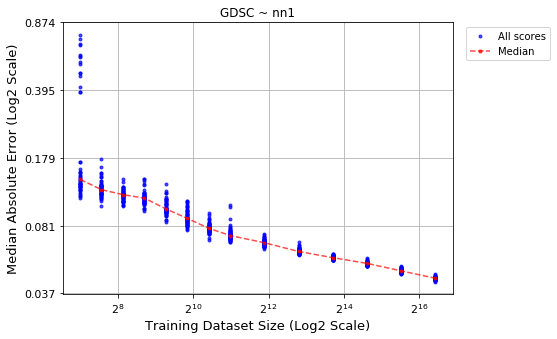

In [29]:
# Plot
# -------------------------------
kwargs.update({'title': f'{src} ~ nn1'})
ax = lc_plots.plot_lc_single_metric(nn1, **kwargs);

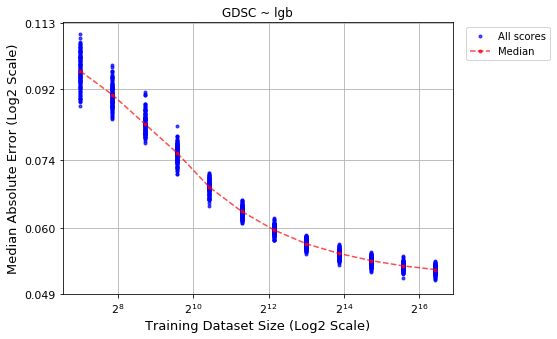

In [30]:
# Plot
# -------------------------------
kwargs.update({'title': f'{src} ~ lgb'})
ax = lc_plots.plot_lc_single_metric(lgb, **kwargs);

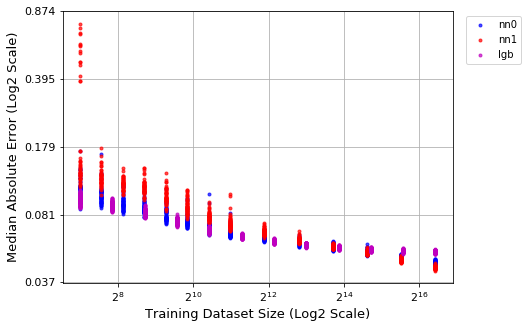

In [31]:
# Plot
# -------------------------------
ax = None
kwargs = {'metric_name': met, 'xtick_scale': xtick_scale, 'ytick_scale': ytick_scale}

nn0 = nn0[nn0.metric==met].reset_index(drop=True)
ax = lc_plots.plot_lc(x=nn0['tr_size'].values, y=nn0['score'].values, color='b', label='nn0', **kwargs, ax=ax);

nn1 = nn1[nn1.metric==met].reset_index(drop=True)
ax = lc_plots.plot_lc(x=nn1['tr_size'].values, y=nn1['score'].values, color='r', label='nn1', **kwargs, ax=ax);

lgb = lgb[lgb.metric==met].reset_index(drop=True)
ax = lc_plots.plot_lc(x=lgb['tr_size'].values, y=lgb['score'].values, color='m', label='lgb', **kwargs, ax=ax);

In [32]:
# nn0[nn0.tr_size == nn0.tr_size.max()].score.values
# nn1[nn1.tr_size == nn1.tr_size.max()].score.values

## Fitting

In [33]:
# # Choose the dataset
# df = nn0.copy(); model = 'nn0'
# # df = nn1.copy(); model = 'nn1'
# # df = lgb.copy(); model = 'LGBM'

# # ----------------
# # Prepare the data
# # ----------------
# df = df[ df['metric']==met ].reset_index(drop=True)
# print('Raw dataset of scores', df.shape)

# # Agg scores
# df['y'] = df['score']
# df = df[df['metric']==met].groupby('tr_size').agg({'y': 'median'}).reset_index()
# print('Agg with median', df.shape)

# # Split dfit and dext
# x_fit_mn = 1000
# x_fit_mx = None

# dfit = subset_data(df, col='tr_size', x_mn=x_fit_mn, x_mx=x_fit_mx)
# dfit = add_weight_col(dfit)

# print('dfit.shape:', dfit.shape)
# print('Train size (dfit):', dfit['tr_size'].unique())

In [34]:
def fit_data(df, x_fit_mn=0, x_fit_mx=None):
    df = df[ df['metric']==met ].reset_index(drop=True)
    df['y'] = df['score']
    df = df[df['metric']==met].groupby('tr_size').agg({'y': 'median'}).reset_index()
    
    dfit = subset_data(df, col='tr_size', x_mn=x_fit_mn, x_mx=x_fit_mx)
    dfit = add_weight_col(dfit)
    return dfit

In [35]:
# Split dfit and dext
x_fit_mn = 1000
x_fit_mx = None
dfit_nn0 = fit_data(nn0, x_fit_mn=x_fit_mn, x_fit_mx=x_fit_mx)
dfit_nn1 = fit_data(nn1, x_fit_mn=x_fit_mn, x_fit_mx=x_fit_mx)
dfit_lgb = fit_data(lgb, x_fit_mn=x_fit_mn, x_fit_mx=x_fit_mx)

In [36]:
pnts_args = {'metric_name': met, 'xtick_scale': xtick_scale, 'ytick_scale': ytick_scale, 'alpha': 0.5, 'ls': '', 'marker': '.'}
fit_args = {'metric_name': met, 'xtick_scale': xtick_scale, 'ytick_scale': ytick_scale, 'alpha': 0.5, 'ls': '--', 'marker': ''}

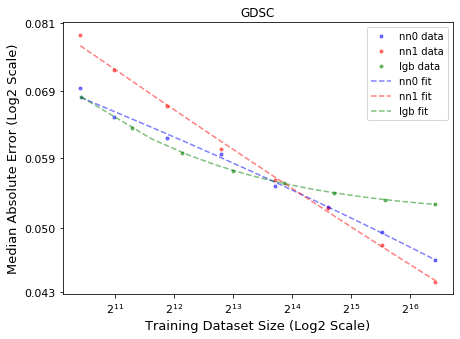

In [37]:
# NN0
xf_nn0 = dfit_nn0['tr_size'].values
yf_nn0 = dfit_nn0['y'].values
cc_nn0 = FitPwrLaw(xf=xf_nn0, yf=yf_nn0, w=dfit_nn0['w'].values)
xf_plot_nn0, yf_plot_nn0 = cc_nn0.calc_fit( x1=xf_nn0[0], x2=xf_nn0[-1] )

# NN1
xf_nn1 = dfit_nn1['tr_size'].values
yf_nn1 = dfit_nn1['y'].values
cc_nn1 = FitPwrLaw(xf=xf_nn1, yf=yf_nn1, w=dfit_nn1['w'].values)
xf_plot_nn1, yf_plot_nn1 = cc_nn1.calc_fit( x1=xf_nn1[0], x2=xf_nn1[-1] )

# NN1
xf_lgb = dfit_lgb['tr_size'].values
yf_lgb = dfit_lgb['y'].values
cc_lgb = FitPwrLaw(xf=xf_lgb, yf=yf_lgb, w=dfit_lgb['w'].values)
xf_plot_lgb, yf_plot_lgb = cc_lgb.calc_fit( x1=xf_lgb[0], x2=xf_lgb[-1] )

# Reset axes
ax = None

# Raw data
ax = lc_plots.plot_lc(x=xf_nn0, y=yf_nn0, ax=ax, **pnts_args, color='b', label='nn0 data')
ax = lc_plots.plot_lc(x=xf_nn1, y=yf_nn1, ax=ax, **pnts_args, color='r', label='nn1 data')
ax = lc_plots.plot_lc(x=xf_lgb, y=yf_lgb, ax=ax, **pnts_args, color='g', label='lgb data')

# Fits
ax = lc_plots.plot_lc(x=xf_plot_nn0, y=yf_plot_nn0, ax=ax, **fit_args, color='b', label='nn0 fit')
ax = lc_plots.plot_lc(x=xf_plot_nn1, y=yf_plot_nn1, ax=ax, **fit_args, color='r', label='nn1 fit')
ax = lc_plots.plot_lc(x=xf_plot_lgb, y=yf_plot_lgb, ax=ax, **fit_args, color='g', label='lgb fit')

# ax.set_title(f'{src} ~ {model}')
ax.set_title(f'{src}')
ax.legend(frameon=True, fontsize=10, loc='best')
ax.grid(False)

In [38]:
display(cc_nn0.coefs)

,coef,est,se,t_val,p_val
0,a,0.185609,0.108431,1.711768,0.147620
1,b,-0.040873,0.040172,-1.017447,0.355619
2,c,-0.070182,0.121432,-0.577949,0.588350


In [39]:
display(cc_nn1.coefs)

,coef,est,se,t_val,p_val
0,a,0.209827,0.027729,7.567051,0.000639
1,b,-0.154952,0.039022,-3.970940,0.010626
2,c,0.008223,0.011456,0.717767,0.505028


In [40]:
display(cc_lgb.coefs)

,coef,est,se,t_val,p_val
0,a,1.156956,0.036803,31.436866,6.115202e-07
1,b,-0.586375,0.004250,-137.957882,3.796005e-10
2,c,0.051373,0.000030,1706.041557,1.313271e-15


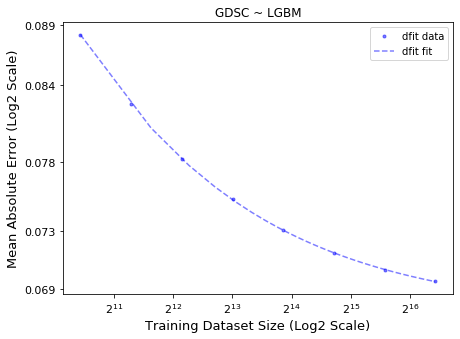

In [55]:
xf = dfit['tr_size'].values
# xe = dext['tr_size'].values
yf = dfit['y'].values
# ye = dext['y'].values

cc = FitPwrLaw(xf=dfit['tr_size'].values, yf=dfit['y'].values, w=dfit['w'].values)
xf_plot, yf_plot = cc.calc_fit( x1=xf[0], x2=xf[-1] )
# xe_plot, ye_plot = cc.calc_fit( x1=xe[0], x2=xe[-1] )

# Reset axes
ax = None

# Raw data
ax = lc_plots.plot_lc(x=xf, y=yf, ax=ax, **pnts_args, color='b', label='dfit data')
# ax = lc_plots.plot_lc(x=xe, y=ye, ax=ax, **pnts_args, color='r', label='dext data')

# Fits
ax = lc_plots.plot_lc(x=xf_plot, y=yf_plot, ax=ax, **fit_args, color='b', label='dfit fit')
# ax = lc_plots.plot_lc(x=xe_plot, y=ye_plot, ax=ax, **fit_args, color='r', label='dext fit')

ax.set_title(f'{src} ~ {model}')
ax.legend(frameon=True, fontsize=10, loc='best')
ax.grid(False)

## Plot together